# TODO
- Correlation analysis
    - features vs features
    - features vs target
- Remove outliers b4 traing
- change features
    - Use only distance?

# Some imports

In [68]:
import os
from IPython.display import display, HTML
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline

os.environ["JAVA_HOME"] = "/home/legorge/jre1.8.0_441"
display(HTML("<style>pre { white-space: pre !important; }</style>"))

from pyspark.sql import SparkSession, functions as F

# Spark Session

In [69]:
spark = (SparkSession.builder 
    .appName("demo") 
    .config("spark.driver.memory", "16g")   # Set driver memory (4 GB in this case)
    .config("spark.executor.memory", "16g")  # Set executor memory (4 GB in this case)
    .getOrCreate()
)

In [70]:
spark

## Get the data

In [71]:
df = spark.read.parquet('data/data.parquet')
df.show()

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|Airport_fee|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+-----------+
|       2| 2024-01-01 00:57:55|  2024-01-01 01:17:43|              1|         1.72|         1|                 N|         186|          79|           2|       17.7|  1.0|    0.5|       0.

In [72]:
100 * df.filter(' total_amount >= 0 ').count() / df.count()

98.802411368187

# Clean the data

In [73]:

cols = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance', 
        'fare_amount', 'total_amount', 'tip_amount', 'tolls_amount']
clean_df = (
        df.select(*cols).filter(' total_amount > 0 ')
        .withColumn('real_amount', F.round(F.col('total_amount') - F.col('tolls_amount') - F.col('tip_amount'), 2))
        .drop('total_amount', 'tip_amount', 'tolls_amount', 'fare_amount')
        .filter(' real_amount > 0 ')
)
clean_df.show(10)


+--------------------+---------------------+-------------+-----------+
|tpep_pickup_datetime|tpep_dropoff_datetime|trip_distance|real_amount|
+--------------------+---------------------+-------------+-----------+
| 2024-01-01 00:57:55|  2024-01-01 01:17:43|         1.72|       22.7|
| 2024-01-01 00:03:00|  2024-01-01 00:09:36|          1.8|       15.0|
| 2024-01-01 00:17:06|  2024-01-01 00:35:01|          4.7|       28.3|
| 2024-01-01 00:36:38|  2024-01-01 00:44:56|          1.4|       15.0|
| 2024-01-01 00:46:51|  2024-01-01 00:52:57|          0.8|       12.9|
| 2024-01-01 00:54:08|  2024-01-01 01:26:31|          4.7|       34.6|
| 2024-01-01 00:49:44|  2024-01-01 01:15:47|        10.82|      54.95|
| 2024-01-01 00:30:40|  2024-01-01 00:58:40|          3.0|       30.4|
| 2024-01-01 00:26:01|  2024-01-01 00:54:12|         5.44|       36.0|
| 2024-01-01 00:28:08|  2024-01-01 00:29:16|         0.04|        8.0|
+--------------------+---------------------+-------------+-----------+
only s

# Feature extraction

In [74]:
# [schema.dataType for schema in clean_df.schema if ]
# dir(clean_df.schema)

final_df = (
  clean_df.withColumn("pickup_day_of_week", F.dayofweek("tpep_pickup_datetime"))
       .withColumn("pickup_hour", F.hour("tpep_pickup_datetime"))
       .withColumn("dropoff_day_of_week", F.dayofweek("tpep_dropoff_datetime"))
       .withColumn("dropoff_hour", F.hour("tpep_dropoff_datetime"))
       .withColumn("duration", F.expr("timestampdiff(SECOND, tpep_pickup_datetime, tpep_dropoff_datetime) / 3600"))
       .drop('tpep_pickup_datetime', 'tpep_dropoff_datetime')
       .cache()
)

final_df.show()

+-------------+-----------+------------------+-----------+-------------------+------------+--------------------+
|trip_distance|real_amount|pickup_day_of_week|pickup_hour|dropoff_day_of_week|dropoff_hour|            duration|
+-------------+-----------+------------------+-----------+-------------------+------------+--------------------+
|         1.72|       22.7|                 2|          0|                  2|           1|                0.33|
|          1.8|       15.0|                 2|          0|                  2|           0|                0.11|
|          4.7|       28.3|                 2|          0|                  2|           0|  0.2986111111111111|
|          1.4|       15.0|                 2|          0|                  2|           0| 0.13833333333333334|
|          0.8|       12.9|                 2|          0|                  2|           0| 0.10166666666666667|
|          4.7|       34.6|                 2|          0|                  2|           1|  0.5

In [75]:
final_df.sort('real_amount').show()

+-------------+-----------+------------------+-----------+-------------------+------------+--------------------+
|trip_distance|real_amount|pickup_day_of_week|pickup_hour|dropoff_day_of_week|dropoff_hour|            duration|
+-------------+-----------+------------------+-----------+-------------------+------------+--------------------+
|         5.18|       0.01|                 3|         18|                  3|          18| 0.25083333333333335|
|         1.41|       0.02|                 7|         18|                  7|          18|  0.1827777777777778|
|         2.41|        0.4|                 7|         16|                  7|          16|                0.25|
|         2.17|       0.43|                 6|         17|                  6|          18|                0.19|
|         6.92|       0.45|                 2|          1|                  2|           1|  0.3338888888888889|
|         5.32|       0.54|                 6|          7|                  6|           8| 0.44

# Split train/test data

In [76]:
def split_dataframe(df, train_weight, test_weight, seed=None):
    # Split the DataFrame into training and test sets
    train_df, test_df = df.randomSplit([train_weight, test_weight], seed)
    return train_df, test_df

train_df, test_df = split_dataframe(final_df, 0.7, 0.3)
# (2 075 719, 888 905)


In [77]:
bla = final_df.count(), train_df.count(), test_df.count()

In [78]:

final_df.sort('real_amount').show()

+-------------+-----------+------------------+-----------+-------------------+------------+--------------------+
|trip_distance|real_amount|pickup_day_of_week|pickup_hour|dropoff_day_of_week|dropoff_hour|            duration|
+-------------+-----------+------------------+-----------+-------------------+------------+--------------------+
|         5.18|       0.01|                 3|         18|                  3|          18| 0.25083333333333335|
|         1.41|       0.02|                 7|         18|                  7|          18|  0.1827777777777778|
|         2.41|        0.4|                 7|         16|                  7|          16|                0.25|
|         2.17|       0.43|                 6|         17|                  6|          18|                0.19|
|         6.92|       0.45|                 2|          1|                  2|           1|  0.3338888888888889|
|         5.32|       0.54|                 6|          7|                  6|           8| 0.44

In [79]:
columns = final_df.columns

# Create filter condition: check if any column is null
filter_condition = " OR ".join([f"{col_name} IS NULL" for col_name in columns])

# Apply filter
df_nulls = final_df.filter(filter_condition)
df_nulls.show()



+-------------+-----------+------------------+-----------+-------------------+------------+--------+
|trip_distance|real_amount|pickup_day_of_week|pickup_hour|dropoff_day_of_week|dropoff_hour|duration|
+-------------+-----------+------------------+-----------+-------------------+------------+--------+
+-------------+-----------+------------------+-----------+-------------------+------------+--------+



# Random Forest Regression

In [80]:
label = 'real_amount'
features = [c for c in train_df.columns if c != label]


In [81]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

def train_random_forest_regression(train_df, features, label):
    # Assemble features into a single vector column
    assembler = VectorAssembler(inputCols=features, outputCol="features")
    
    # Define the Random Forest Regression model
    rf = RandomForestRegressor(featuresCol="features", labelCol=label)
    
    # Set up the Pipeline
    pipeline = Pipeline(stages=[assembler, rf])
    
    # Fit the model on the training data
    model = pipeline.fit(train_df)
    
    # Print feature importances
    print("Feature Importances: " + str(model.stages[-1].featureImportances))
    
    return model  # Return the trained model

def evaluate_model(model, test_df, label):
    # Generate predictions on the test dataset
    predictions = model.transform(test_df)

    predictions.show()
    
    # Define evaluators for RMSE and R²
    rmse_evaluator = RegressionEvaluator(labelCol=label, predictionCol="prediction", metricName="rmse")
    r2_evaluator = RegressionEvaluator(labelCol=label, predictionCol="prediction", metricName="r2")
    
    # Compute metrics
    rmse = rmse_evaluator.evaluate(predictions)
    r2 = r2_evaluator.evaluate(predictions)
    
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
    print(f"R² Score: {r2:.4f}")
    
    return {"rmse": rmse, "r2": r2}


In [82]:
model = train_random_forest_regression(train_df, features=features, label=label)


25/03/10 22:40:29 WARN MemoryStore: Not enough space to cache rdd_89_10 in memory! (computed 28.5 MiB so far)
25/03/10 22:40:29 WARN BlockManager: Persisting block rdd_89_10 to disk instead.
25/03/10 22:40:32 WARN MemoryStore: Not enough space to cache rdd_89_2 in memory! (computed 96.2 MiB so far)
25/03/10 22:40:32 WARN BlockManager: Persisting block rdd_89_2 to disk instead.
25/03/10 22:40:35 WARN MemoryStore: Not enough space to cache rdd_89_2 in memory! (computed 96.2 MiB so far)
25/03/10 22:40:38 WARN MemoryStore: Not enough space to cache rdd_89_2 in memory! (computed 96.2 MiB so far)
25/03/10 22:40:40 WARN MemoryStore: Not enough space to cache rdd_89_2 in memory! (computed 96.2 MiB so far)
25/03/10 22:40:42 WARN MemoryStore: Not enough space to cache rdd_89_2 in memory! (computed 96.2 MiB so far)
25/03/10 22:40:46 WARN MemoryStore: Not enough space to cache rdd_89_2 in memory! (computed 96.2 MiB so far)


Feature Importances: (6,[0,1,2,3,4,5],[0.6115851431902343,0.0010480408867903851,0.004463642851397309,0.0006370012287874262,0.00223071888086153,0.380035452961929])


In [90]:

metrics = evaluate_model(model, test_df, label=label)



+-------------+-----------+------------------+-----------+-------------------+------------+--------------------+--------------------+------------------+
|trip_distance|real_amount|pickup_day_of_week|pickup_hour|dropoff_day_of_week|dropoff_hour|            duration|            features|        prediction|
+-------------+-----------+------------------+-----------+-------------------+------------+--------------------+--------------------+------------------+
|          0.0|        1.0|                 1|          0|                  1|           0| 0.03638888888888889|[0.0,1.0,0.0,1.0,...| 20.00724635933387|
|          0.0|        1.0|                 2|          4|                  2|           4|0.004166666666666667|[0.0,2.0,4.0,2.0,...|20.179145080067002|
|          0.0|        1.0|                 2|         15|                  2|          15|0.005277777777777778|[0.0,2.0,15.0,2.0...|19.419999170716185|
|          0.0|        1.0|                 2|         17|                  2|    

Root Mean Squared Error (RMSE): 10.0317
R² Score: 0.7179


In [84]:
metrics

{'rmse': 10.031656161261123, 'r2': 0.7179226142900628}

In [96]:
from pyspark.sql import functions as F

def remove_outliers(df, col_name):
    # Calculate Q1 (25th percentile) and Q3 (75th percentile)
    Q1 = df.approxQuantile(col_name, [0.25], 0.01)[0]
    Q3 = df.approxQuantile(col_name, [0.75], 0.01)[0]
    
    # Calculate IQR
    IQR = Q3 - Q1
    
    # Define the lower and upper bounds for outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Filter the DataFrame to remove outliers
    filtered_df = df.filter((df[col_name] >= lower_bound) & (df[col_name] <= upper_bound))
    
    return filtered_df


In [97]:
filtered_df = remove_outliers(test_df, label)

In [93]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_actual_vs_predicted(model, test_df, label):
    # Generate predictions
    predictions = model.transform(test_df)
    
    # Select actual values and predictions
    actual_vs_pred_df = predictions.select(label, "prediction") \
                                   .toPandas()  # Convert to Pandas for easy plotting
    
    # Plot Actual vs Predicted
    plt.figure(figsize=(8, 6))
    plt.scatter(actual_vs_pred_df[label], actual_vs_pred_df["prediction"], alpha=0.5)
    plt.plot([min(actual_vs_pred_df[label]), max(actual_vs_pred_df[label])], 
             [min(actual_vs_pred_df[label]), max(actual_vs_pred_df[label])], color="red", linestyle="--")
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Actual vs Predicted Values")
    plt.show()

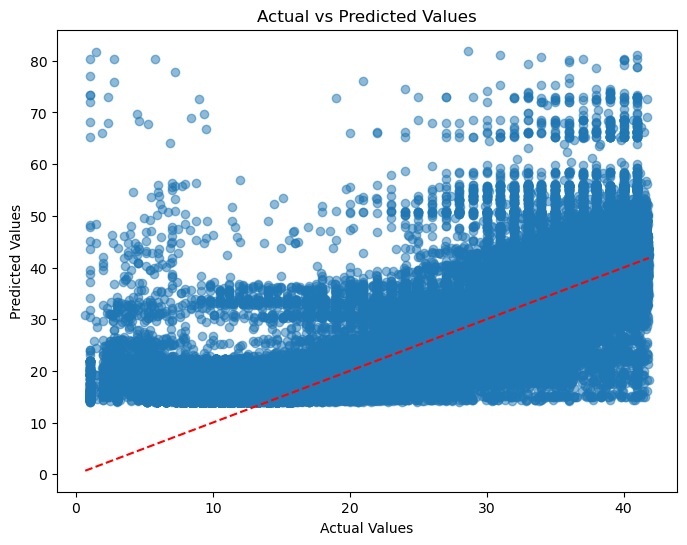

In [98]:
plot_actual_vs_predicted(model, filtered_df, label=label)